Device for torch operations: cpu


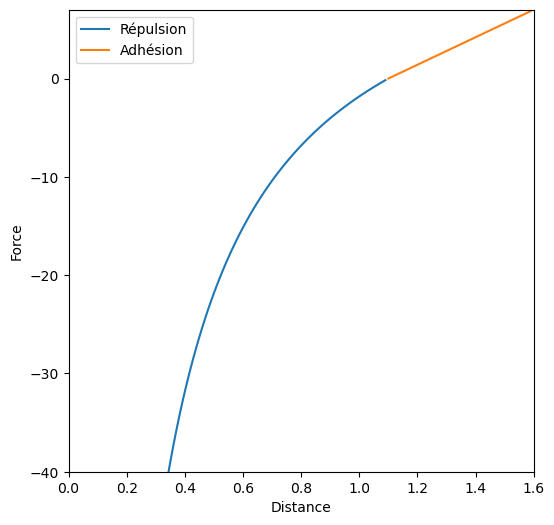

105 cells


KeyboardInterrupt: 

In [18]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

### Importation des bibliothèques ###
import math
import os
import sys
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
import functions_analyze as lib
from scipy.signal import find_peaks

# Définition de l'appareil (CPU ou GPU) pour les opérations PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device for torch operations:", device)

def force_field_inbox(coordinates_diff, distances, Req, R0, Frep, Fadh,
                      coeff_a=None, coeff_rep=None):
    """
    Calcule le champ de forces entre les cellules en prenant en compte les forces
    de répulsion et d'adhésion, selon les distances entre les cellules.

    Paramètres:
    - coordinates_diff: Tensor des différences de coordonnées entre les cellules
    - distances: Tensor des distances entre les cellules
    - Req: Rayon d'équilibre (μm)
    - R0: Rayon d'interaction maximale (μm)
    - Frep: Intensité de la force de répulsion
    - Fadh: Intensité de la force d'adhésion
    - coeff_a: Coefficient pour la force quadratique (non utilisé ici)
    - coeff_rep: Coefficient pour ajuster la force de répulsion
    """
    Rlim = 0.000001  # Limite inférieure pour éviter la division par zéro
    R = torch.norm(coordinates_diff, dim=2)  # Calcul des distances entre les cellules
    # Empêche la force de répulsion de diverger en fixant une valeur minimale pour R
    R = torch.where(R > Rlim * torch.ones(1, device=device),
                    R, Rlim * torch.ones(1, device=device)).to(device)
    
    # Calcul de la force d'adhésion (linéaire entre Req et R0)
    force = torch.where(torch.logical_and(R < R0, R > Req),
                        -((Fadh / (R0 - Req)) * R - Fadh * Req / (R0 - Req)),
                        torch.zeros_like(R)).to(device)
    
    # Calcul de la force de répulsion (proportionnelle à 1/R)
    force = torch.where(R <= Req,
                        -Frep * coeff_rep * (1 / Req - 1 / R), force).to(device)
    
    # Calcul du champ de forces résultant en sommant les contributions des autres cellules
    # On normalise les vecteurs de différence pour obtenir les directions
    force_field = torch.sum(force[:, :, None] *
                            torch.nn.functional.normalize(coordinates_diff, dim=2), axis=1)
    
    return force_field

def plot_environment(cells, camp_field, space_size, axis, iteration=None):
        """
        Trace l'environnement de simulation, y compris les positions des cellules et
        la concentration du champ de cAMP.

        Paramètres:
        - cells: Liste des cellules
        - camp_field: Objet représentant le champ de cAMP
        - space_size: Taille de l'espace de simulation
        - axis: L'axe matplotlib sur lequel tracer
        - iteration: Numéro de l'itération (utilisé pour le titre)
        """
        axis.set_xlim(0, space_size)
        axis.set_ylim(0, space_size)

        # Traçage de la carte de concentration du cAMP
        extent = [0, space_size, 0, space_size]
        cmap = plt.cm.viridis  # Palette de couleurs pour la concentration
        im = axis.imshow(camp_field.signal.T.cpu().numpy(), origin='lower', extent=extent, cmap=cmap, alpha=0.5)

        # Récupération des positions des cellules
        x = [cell.position[0].item() for cell in cells]
        y = [cell.position[1].item() for cell in cells]

        # Attribution des couleurs en fonction de la population
        colors = ['blue' if cell.pop == 'Population 1' else 'red' for cell in cells]

        # Tracé des cellules sur le graphique
        axis.scatter(x, y, s=5, color=colors, alpha=0.5, edgecolors='k')

        axis.set_xlabel('Position X (micromètres)')
        axis.set_ylabel('Position Y (micromètres)')
        axis.set_title(f'Temps: {iteration * DELTA_T:.2f} min')

def plot_function(pas, Req, R0, Frep, Fadh, a, coeff_rep):
    """
    Trace les fonctions de force de répulsion et d'adhésion en fonction de la distance.

    Paramètres:
    - pas: Pas d'échantillonnage pour les distances
    - Req: Rayon d'équilibre (μm)
    - R0: Rayon d'interaction maximale (μm)
    - Frep: Intensité de la force de répulsion
    - Fadh: Intensité de la force d'adhésion
    - a: Coefficient quadratique (non utilisé ici)
    - coeff_rep: Coefficient pour ajuster la force de répulsion
    """
    # Calcul des coefficients pour les forces (non utilisés ici)
    b = (Fadh - a * (R0 ** 2 - Req ** 2)) / (R0 - Req)
    c = -Req * (a * Req + (Fadh - a * (R0 ** 2 - Req ** 2)) / (R0 - Req))

    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, R0)
    plt.ylim(-Frep, Fadh)

    # Tracé de la force de répulsion pour R entre 0 et Req
    axis.plot(np.arange(pas, Req, pas), [
              Frep * coeff_rep * (1 / Req - 1 / R) for R in np.arange(pas, Req, pas)], label='Répulsion')
    # Tracé de la force d'adhésion pour R entre Req et R0
    axis.plot(np.arange(Req, R0, pas), [
              (Fadh / (R0 - Req)) * (R - Req) for R in np.arange(Req, R0, pas)], label='Adhésion')

    plt.xlabel('Distance')
    plt.ylabel('Force')
    plt.legend()
    plt.show()

def autovel(dX, n, tau, noise, dt, persistence):
    """
    Calcule la nouvelle direction des cellules basée sur leur déplacement,
    leur direction précédente, le bruit, le temps caractéristique tau, et la persistance.

    Paramètres:
    - dX: Déplacement de la cellule
    - n: Vecteur directionnel précédent de la cellule
    - tau: Temps caractéristique pour l'alignement directionnel
    - noise: Intensité du bruit angulaire
    - dt: Pas de temps de la simulation
    - persistence: Persistance du mouvement (non utilisé ici)

    Retourne:
    - new_direction: Nouvelle direction normalisée de la cellule
    """    
    # Normalise le vecteur de déplacement
    dX_norm = torch.nn.functional.normalize(dX, dim=1) * 0.9999999
    if persistence == 1:
        persistence = 0.9999999
    # Calcule l'angle actuel du déplacement
    theta = torch.atan2(dX_norm[:, 1], dX_norm[:, 0]).to(device)
    
    # Calcule le changement d'angle basé sur le vecteur d'orientation précédent
    dtheta = torch.arcsin((n[:, 0] * dX_norm[:, 1] - n[:, 1] * dX_norm[:, 0])) * dt / tau

    # Génère du bruit aléatoire pour la perturbation de l'angle
    rnd = (2 * math.pi * (torch.rand(len(dX), 1, device=device) - 0.5)) * noise * np.sqrt(dt)
    
    # Mise à jour de l'angle
    theta_update = theta + dtheta + rnd.squeeze(1)

    # Calcule la nouvelle direction à partir de l'angle mis à jour
    new_dir_x = torch.cos(theta_update)
    new_dir_y = torch.sin(theta_update)
    
    # Crée un nouveau tenseur pour la direction mise à jour
    new_direction = torch.stack((new_dir_x, new_dir_y), dim=1)
    
    return new_direction

def compute_local_gradient(signal_grid, position, grid_resolution, r_sensing):
    """
    Calcule le gradient local du cAMP à la position donnée.

    Paramètres:
    - signal_grid: Grille de concentration du cAMP
    - position: Position de la cellule
    - grid_resolution: Résolution de la grille (taille d'une cellule de la grille)
    - r_sensing: Rayon de détection du gradient par la cellule

    Retourne:
    - grad: Vecteur gradient du cAMP à la position de la cellule
    """
    x_idx = int(position[0].item() / grid_resolution) % signal_grid.shape[0]
    y_idx = int(position[1].item() / grid_resolution) % signal_grid.shape[1]
    grid_size_x, grid_size_y = signal_grid.shape

    # Déterminer le nombre de mailles correspondant au rayon de détection
    n_cells = int(r_sensing / grid_resolution)

    grad_x = 0.0
    grad_y = 0.0
    count = 0

    # Parcourir les positions dans la zone de détection
    for dx in range(-n_cells, n_cells + 1):
        for dy in range(-n_cells, n_cells + 1):
            distance = math.hypot(dx * grid_resolution, dy * grid_resolution)
            if 0 < distance <= r_sensing:
                x_neighbor = (x_idx + dx) % grid_size_x
                y_neighbor = (y_idx + dy) % grid_size_y

                # Calcul de la différence de concentration
                delta_c = signal_grid[x_neighbor, y_neighbor] - signal_grid[x_idx, y_idx]

                # Calcul du vecteur directionnel vers le voisin
                unit_vector = torch.tensor([dx * grid_resolution, dy * grid_resolution], device=device) / distance

                # Ajout de la contribution au gradient
                grad_x += delta_c * unit_vector[0]
                grad_y += delta_c * unit_vector[1]
                count += 1

    if count > 0:
        grad_x /= count
        grad_y /= count

    grad = torch.tensor([grad_x, grad_y], device=device)
    return grad

class CellAgent:
    def __init__(self, id, pop, position, velocity,
                 velocity_magnitude, persistence, space_size,
                 tau, noise, cell_params, sensitivity_cAMP_threshold):
        """
        Classe représentant une cellule individuelle dans la simulation.

        Paramètres:
        - id: Identifiant unique de la cellule
        - pop: Type de population (e.g., 'Population 1' ou 'Population 2')
        - position: Position initiale de la cellule (tensor)
        - velocity: Vitesse initiale de la cellule (tensor)
        - velocity_magnitude: Norme de la vitesse initiale
        - persistence: Persistance du mouvement
        - space_size: Taille de l'espace de simulation
        - tau: Temps caractéristique pour l'alignement directionnel
        - noise: Intensité du bruit dans la direction
        - cell_params: Dictionnaire des paramètres pour le modèle de FitzHugh-Nagumo
        - sensitivity_cAMP_threshold: Seuil de sensibilité au cAMP
        """
        self.id = id  # ID unique de la cellule
        self.pop = pop  # Type de population
        self.position_init = position.clone().to(device)  # Position initiale (pour référence)
        self.position = position.clone().to(device)  # Position actuelle
        self.velocity = velocity.clone().to(device)  # Vitesse actuelle
        self.velocity_magnitude = velocity_magnitude  # Norme de la vitesse
        self.persistence = persistence  # Persistance du mouvement
        self.space_size = space_size  # Taille de l'espace
        self.tau = tau  # Temps caractéristique pour l'alignement directionnel
        self.noise = noise  # Intensité du bruit
        self.direction = torch.nn.functional.normalize(velocity, p=2, dim=0)  # Direction normalisée
        # États A et R pour le modèle de FitzHugh-Nagumo
        self.A = torch.tensor(0.5, device=device)  # État de l'activateur A
        self.R = torch.tensor(0.5, device=device)  # État du répresseur R
        self.cell_params = cell_params  # Paramètres du modèle de FitzHugh-Nagumo
        # Paramètres pour la production du cAMP
        self.D = cell_params['D']  # Taux de production de cAMP
        self.a0 = cell_params['a0']  # Production basale de cAMP
        self.af = cell_params['af']  # Seuil d'activation pour la production de cAMP
        self.sensitivity_threshold = sensitivity_cAMP_threshold  # Seuil de sensibilité au cAMP

    def update_state(self, signal_value, dt):
        """
        Met à jour les états internes A et R de la cellule en fonction du signal cAMP local.

        Paramètres:
        - signal_value: Valeur du signal cAMP à la position de la cellule
        - dt: Pas de temps de la simulation
        """
        # Extraction des paramètres du modèle
        a = self.cell_params['a']
        Kd = self.cell_params['Kd']
        gamma = self.cell_params['gamma']
        c0 = self.cell_params['c0']
        epsilon = self.cell_params['epsilon']
        sigma = self.cell_params['sigma']
        noise_flag = self.cell_params.get('noise', True)

        # Calcul de l'entrée I_S en fonction du signal cAMP local
        I_S = a * torch.log1p(signal_value / Kd)

        # Mise à jour de l'état A (activateur)
        dA = (self.A - (self.A ** 3) / 3 - self.R + I_S) * dt
        if noise_flag:
            dA += sigma * math.sqrt(dt) * torch.randn((), device=device)  # Ajout de bruit
        self.A += dA

        # Mise à jour de l'état R (répresseur)
        dR = (self.A - gamma * self.R + c0) * epsilon * dt
        self.R += dR

class Population:
    def __init__(self, num_cells, space_size, velocity_magnitude,
                 persistence, min_distance, pop_tag, ecart_type,
                 tau, noise, cell_params, sensitivity_cAMP_threshold):
        """
        Classe représentant une population de cellules.

        Paramètres:
        - num_cells: Nombre de cellules dans la population
        - space_size: Taille de l'espace de simulation
        - velocity_magnitude: Norme moyenne de la vitesse des cellules
        - persistence: Persistance du mouvement
        - min_distance: Distance minimale entre les cellules à l'initialisation
        - pop_tag: Identifiant de la population (e.g., 'Population 1')
        - ecart_type: Écart-type pour la distribution des vitesses
        - tau: Temps caractéristique pour l'alignement directionnel
        - noise: Intensité du bruit dans la direction
        - cell_params: Dictionnaire des paramètres pour le modèle de FitzHugh-Nagumo
        - sensitivity_cAMP_threshold: Seuil de sensibilité au cAMP
        """
        self.num_cells = num_cells
        self.space_size = space_size
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.min_distance = min_distance
        self.pop_tag = pop_tag  # Identifiant de la population
        self.ecart_type = ecart_type  # Écart-type pour les vitesses initiales
        self.tau = tau
        self.noise = noise
        self.cell_params = cell_params
        self.sensitivity_cAMP_threshold = sensitivity_cAMP_threshold
        self.cells = []
        self.initialize_cells()

    def initialize_cells(self):
        """
        Initialise les cellules de la population en leur attribuant des positions
        et des vitesses initiales, tout en respectant la distance minimale entre elles.
        """
        global cell_id_counter  # Compteur global pour les identifiants de cellules
        # Génération de positions aléatoires dans l'espace
        positions = torch.rand((self.num_cells, 2), device=device) * self.space_size
        # Génération de directions aléatoires normalisées
        directions = torch.nn.functional.normalize(torch.empty_like(positions).uniform_(-1, 1), dim=1)
        # Génération de vitesses suivant une distribution normale
        vitesses_gaussiennes = torch.normal(mean=self.velocity_magnitude, std=self.ecart_type, size=(self.num_cells,), device=device)

        # Logique pour placer les cellules en respectant la distance minimale
        if self.min_distance != 0:
            grid_size = int(np.ceil(self.space_size / self.min_distance))
            grid = [[[] for _ in range(grid_size)] for _ in range(grid_size)]
            
            for i, position in enumerate(positions):
                # Essayer de placer la cellule sans conflits
                placed = False
                while not placed:
                    grid_x = int(position[0] / self.min_distance)
                    grid_y = int(position[1] / self.min_distance)
                    # Vérification des conflits avec les cellules voisines
                    conflicts = any(torch.norm(position - other_position) < self.min_distance for other_position in grid[grid_x][grid_y])
                    if not conflicts:
                        for dx in [-1, 0, 1]:
                            for dy in [-1, 0, 1]:
                                if dx == 0 and dy == 0:
                                    continue
                                nx, ny = grid_x + dx, grid_y + dy
                                if 0 <= nx < grid_size and 0 <= ny < grid_size:
                                    conflicts = any(torch.norm(position - other_position) < self.min_distance for other_position in grid[nx][ny])
                                    if conflicts:
                                        break
                            if conflicts:
                                break
                    if not conflicts:
                        # Placement réussi sans conflit
                        grid[grid_x][grid_y].append(position)
                        velocity = directions[i] * vitesses_gaussiennes[i]
                        self.cells.append(CellAgent(cell_id_counter, self.pop_tag, position, velocity,
                                                    vitesses_gaussiennes[i], self.persistence, self.space_size,
                                                    self.tau, self.noise, self.cell_params, self.sensitivity_cAMP_threshold))
                        cell_id_counter += 1
                        placed = True
                    else:
                        # Générer une nouvelle position aléatoire
                        position = torch.rand(2, device=device) * self.space_size
        else:
            # Si la distance minimale est zéro, on place les cellules sans contrainte
            for i, position in enumerate(positions):
                velocity = directions[i] * vitesses_gaussiennes[i]
                self.cells.append(CellAgent(cell_id_counter, self.pop_tag, position, velocity,
                                            vitesses_gaussiennes[i], self.persistence, self.space_size,
                                            self.tau, self.noise, self.cell_params, self.sensitivity_cAMP_threshold))
                cell_id_counter += 1

class Surface:
    def get_friction(self, position):
        """
        Retourne la friction de la surface à une position donnée.
        Ici, elle est générée aléatoirement entre 0 et 0.2.

        Paramètres:
        - position: Position pour laquelle on veut la friction (non utilisée)

        Retourne:
        - friction: Valeur de friction à la position donnée
        """
        friction = torch.empty(1).uniform_(0, 0.2).to(device)
        return friction.item()
        
class cAMP:
    def __init__(self, space_size, cell_params, initial_condition=None):
        """
        Classe représentant le champ de concentration du cAMP dans l'espace.

        Résout l'équation de diffusion-dégradation-production du cAMP :
            ∂S/∂t = D_cAMP ∇²S - aPDE * S + P(x, y, t)

        Le terme de production est défini par :
            P(x, y, t) = Σ_cells [ a0 + D_cell * H(A_cell - af) * δ(x - x_cell, y - y_cell) ]
                
        Où :
        - S(x, y, t) : Concentration de cAMP à la position (x, y) et au temps t.
        - D_cAMP : Coefficient de diffusion du cAMP.
        - ∇²S : Laplacien de S, représentant la diffusion spatiale.
        - aPDE : Taux de dégradation du cAMP.
        - P(x, y, t) : Terme de production de cAMP par les cellules activées.
        - a0 : Taux de production basal de cAMP.
        - D_cell : Taux de production de cAMP par une cellule activée.

        Paramètres:
        - space_size: Taille de l'espace de simulation.
        - cell_params: Dictionnaire des paramètres du modèle de FitzHugh-Nagumo
        - initial_condition: Condition initiale de la concentration de cAMP (optionnelle).
        """
        self.space_size = space_size
        self.grid_resolution = cell_params['grid_resolution']
        self.grid_size = int(space_size / self.grid_resolution)
        self.D_cAMP = cell_params['D_cAMP']  # Coefficient de diffusion
        self.aPDE = cell_params['aPDE']      # Taux de dégradation
        self.a0 = cell_params['a0']          # Production basale de cAMP
        self.dx = self.grid_resolution       # Pas spatial
        self.dt = DELTA_T                     # Pas de temps de la simulation

        # Création de la grille de coordonnées
        x = torch.linspace(0, space_size, self.grid_size, device=device)
        y = torch.linspace(0, space_size, self.grid_size, device=device)
        self.X, self.Y = torch.meshgrid(x, y, indexing='ij')

        # Initialisation de la grille de concentration du cAMP
        if initial_condition is None:
            # Par défaut, concentration nulle partout
            self.signal = torch.zeros((self.grid_size, self.grid_size), device=device)
        else:
            # Si une fonction ou un tableau est fourni pour l'état initial
            if callable(initial_condition):
                # Utiliser la fonction pour définir la concentration initiale
                self.signal = initial_condition(self.X, self.Y)
            elif isinstance(initial_condition, torch.Tensor):
                # Vérifier que la taille correspond
                if initial_condition.shape == (self.grid_size, self.grid_size):
                    self.signal = initial_condition.to(device)
                else:
                    raise ValueError("La forme de initial_condition ne correspond pas à la grille.")
            else:
                # Supposer que c'est une valeur scalaire
                self.signal = torch.full((self.grid_size, self.grid_size), initial_condition, device=device)

    def compute_laplacian(self, S):
        """
        Calcule le Laplacien du signal S avec des conditions aux limites périodiques.

        Paramètres:
        - S: Grille de concentration du cAMP

        Retourne:
        - laplacian_S: Grille du Laplacien de S
        """
        # Utilisation de torch.roll pour implémenter les conditions périodiques
        laplacian_S = (
            torch.roll(S, shifts=1, dims=0) + torch.roll(S, shifts=-1, dims=0) +
            torch.roll(S, shifts=1, dims=1) + torch.roll(S, shifts=-1, dims=1) -
            4 * S
        ) / self.dx ** 2
        return laplacian_S

    def update(self, cells):
        """
        Met à jour la concentration du cAMP en fonction de la production par les cellules,
        de la diffusion et de la dégradation.

        Paramètres:
        - cells: Liste des cellules dans la simulation
        """
        # Production de cAMP par les cellules
        A_grid = torch.zeros_like(self.signal)
        for cell in cells:
            x_idx = int(cell.position[0].item() / self.grid_resolution) % self.grid_size
            y_idx = int(cell.position[1].item() / self.grid_resolution) % self.grid_size
            # Production basale de cAMP
            A_grid[x_idx, y_idx] += cell.a0
            # Production supplémentaire si la cellule est activée
            if cell.A > cell.af:
                A_grid[x_idx, y_idx] += cell.D  # D est le taux de production de cAMP par les cellules activées

        # Diffusion et dégradation du cAMP
        laplacian_S = self.compute_laplacian(self.signal)
        self.signal += self.dt * (self.D_cAMP * laplacian_S - self.aPDE * self.signal + A_grid)
        self.signal = torch.clamp(self.signal, min=0)  # Pour éviter les valeurs négatives

        # Vérification des NaN dans le signal
        if torch.isnan(self.signal).any() or torch.isinf(self.signal).any():
            print(f"NaN or Inf detected in cAMP signal at iteration corresponding to time {self.dt * iteration:.2f} min")
            sys.exit(1)

    def get_signal_at_position(self, position):
        """
        Renvoie la concentration du cAMP à une position donnée, avec conditions périodiques.

        Paramètres:
        - position: Position pour laquelle on veut connaître la concentration de cAMP

        Retourne:
        - Concentration de cAMP à la position donnée
        """
        x_idx = int(position[0].item() / self.grid_resolution) % self.grid_size
        y_idx = int(position[1].item() / self.grid_resolution) % self.grid_size
        return self.signal[x_idx, y_idx]

PLOT = True

# In[Simulation parameters]
# Paramètres de l'espace
SPACE_SIZE = 50  # Taille de l'espace de simulation en micromètres

# Paramètres temporels
TIME_SIMU = 1000  # Temps total de simulation en minutes
# DELTA_T = 0.001 
DELTA_T =  (cell_params['grid_resolution']**2)/(4*cell_params['D_cAMP'])  # Pas de temps de la simulation en minutes (réduit pour stabilité)
#D'après le critère de stabilité de Couran_Friedrichs_Lewy (CFL) delta_T <= ((Δx)**2)/(4*D_cAMP)) 
 
PLOT_INTERVAL = 100  # Intervalle pour la sauvegarde des images
MU = 1  # Mobilité (μm / min·kg⁻¹)
F_REP = 40  # Intensité de la force de répulsion
F_ADH = 7  # Intensité de la force d'adhésion
R_EQ = 1.1  # Rayon d'équilibre (μm)
R_0 = 1.6  # Rayon maximal d'interaction (μm)
MIN_DISTANCE_INIT = R_EQ  # Distance minimale entre cellules à l'initialisation
COEFF_CARRE = 50  # Coefficient quadratique (non utilisé ici)
COEFF_REP = 0.5  # Coefficient pour ajuster la force de répulsion
# Trace la fonction de force pour visualiser les forces de répulsion et d'adhésion
plot_function(pas=0.01, Req=R_EQ, R0=R_0, Frep=F_REP,
              Fadh=F_ADH, a=COEFF_CARRE, coeff_rep=COEFF_REP)

# Facteur de fluctuation pour la vitesse
FLUCTUATION_FACTOR = 3

# Définition des cellules
PACKING_FRACTION = 0.04  # Fraction de l'espace occupée par les cellules
# Calcul du nombre de cellules en fonction de la fraction de remplissage
N_CELLS = int((PACKING_FRACTION * SPACE_SIZE ** 2) /
              (math.pi * ((R_EQ / 2) ** 2)))  # Nombre total de cellules
print(N_CELLS, "cells")
# Paramètres de la Population 1
velocity_magnitude_pop1 = 0 * 3  # Vitesse moyenne des cellules de la population 1 (μm/min)
ECART_TYPE_POP1 = 0.3  # Écart-type de la vitesse pour la population 1
NOISE_POP_1 = 0 * 8  # Intensité du bruit pour la population 1
TAU_POP_1 = 5  # Temps caractéristique pour la population 1
PERSISTENCE_POP1 = 0  # Persistance du mouvement pour la population 1
SENSITIVITY_cAMP_THRESHOLD_POP1 = 0.1

# Paramètres de la Population 2
velocity_magnitude_pop2 = 0 * 8  # Vitesse moyenne des cellules de la population 2 (μm/min)
ECART_TYPE_POP2 = 0.5  # Écart-type de la vitesse pour la population 2
NOISE_POP_2 = 0 * 5  # Intensité du bruit pour la population 2
TAU_POP_2 = 5  # Temps caractéristique pour la population 2
PERSISTENCE_POP2 = 0  # Persistance du mouvement pour la population 2
SENSITIVITY_cAMP_THRESHOLD_POP2 = 0.1

R_SENSING_GRAD = 10.0  # Distance en μm sur laquelle la cellule peut sentir le gradient

# Paramètres des cellules pour le modèle de FitzHugh-Nagumo
cell_params = {
    'c0': 1.0,        # Terme constant dans l'équation de R
    'a': 5.0,         # Couplage entre le signal et l'activateur A
    'gamma': 0.1,     # Taux de relaxation du répresseur R
    'Kd': 0.5,        # Ajuster Kd pour définir la sensibilité au cAMP
    'sigma': 0.05,    # Intensité du bruit pour A
    'epsilon': 0.2,   # Ajuster le taux de relaxation de R
    'D': 150.0,         # Taux de production de cAMP par les cellules activées (réduit)
    'a0': 0.0,        # Production basale de cAMP
    'af': 0.1,        # Seuil d'activation pour la production de cAMP
    'noise': True,
    'D_cAMP': 400.0,   # Coefficient de diffusion du cAMP
    'aPDE': 1.0,      # Taux de dégradation du cAMP
    'grid_resolution': 0.5,  # Taille des cellules de la grille (μm)
    'chemotaxis_sensitivity' : 0.5 # Paramètre de chimiotaxie (sensibilité au gradient de cAMP)
    #C'est le % de suivi de la direction en cours, avec alignment avec le grad cAMP alentours. 
}


# Définition des populations
cell_id_counter = 0  # Initialisation du compteur d'ID des cellules
population1 = Population(num_cells=int(N_CELLS / 2), space_size=SPACE_SIZE,
                         velocity_magnitude=velocity_magnitude_pop1,
                         persistence=PERSISTENCE_POP1, ecart_type=ECART_TYPE_POP1,
                         min_distance=MIN_DISTANCE_INIT, pop_tag="Population 1",
                         tau=TAU_POP_1, noise=NOISE_POP_1, cell_params=cell_params,
                         sensitivity_cAMP_threshold=SENSITIVITY_cAMP_THRESHOLD_POP1)

population2 = Population(num_cells=int(N_CELLS / 2), space_size=SPACE_SIZE,
                         velocity_magnitude=velocity_magnitude_pop2,
                         persistence=PERSISTENCE_POP2, ecart_type=ECART_TYPE_POP2,
                         min_distance=MIN_DISTANCE_INIT, pop_tag="Population 2",
                         tau=TAU_POP_2, noise=NOISE_POP_2, cell_params=cell_params,
                         sensitivity_cAMP_threshold=SENSITIVITY_cAMP_THRESHOLD_POP2)

# Combinaison des cellules des deux populations
cells = population1.cells + population2.cells

surface = Surface()  # Création d'une instance de Surface (non utilisée ici)

# In[Initialisation]

##### Gradient nul : valeur fixe ########
def gradient_initial_condition(X, Y):
    return torch.full_like(X, 0.5, device=device)

# # Fonction pour créer un gradient de concentration de 0 en haut à 100 en bas
# def gradient_initial_condition(X, Y):
#     return (Y / SPACE_SIZE) * 100.0  # Y varie de 0 à SPACE_SIZE

##### Gradient linéaire max au centre min en hau et bas #######
# def gradient_initial_condition(X, Y):
#     max_concentration = 25.0  # Valeur maximale de la concentration au milieu
#     return (max_concentration * (1 - ((2 * (Y - SPACE_SIZE / 2) / SPACE_SIZE) ** 2))).to(device)

##### Gradient linéaire radial partant du centre #######
# def gradient_initial_condition(X, Y):
#     X_c = SPACE_SIZE / 2
#     Y_c = SPACE_SIZE / 2
#     R_max = math.sqrt(2) * (SPACE_SIZE / 2)  # Distance maximale au coin de l'espace
#     R = torch.sqrt((X - X_c) ** 2 + (Y - Y_c) ** 2)
#     max_concentration = 10.0
#     signal = max_concentration * (1 - R / R_max)
#     signal = torch.clamp(signal, min=0.0)  # Éviter les valeurs négatives
#     return signal.to(device)
# Initialisation de la grille de cAMP avec le gradient initial
camp_field = cAMP(SPACE_SIZE, cell_params,
                  initial_condition=gradient_initial_condition)

positions = torch.stack([cell.position_init for cell in cells])
V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device=device).unsqueeze(1)
direction = torch.stack([cell.direction for cell in cells])
positions = torch.stack([cell.position for cell in cells])

# Plot du l'état initial
if PLOT:
    # Définition du chemin pour sauvegarder les images
    PATH = f'./simu/v1{velocity_magnitude_pop1}v2{velocity_magnitude_pop2}a{COEFF_CARRE}coefrep{COEFF_REP}fadh{F_ADH}frep{F_REP}/'
    if not os.path.exists(PATH):
        os.makedirs(PATH)
    else:
        print("WARNING : FOLDER DOES ALREADY EXIST!")
        sys.exit(0)
    
    # Création d'une figure et d'un axe pour le tracé initial
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_environment(cells, camp_field, SPACE_SIZE, axis=ax, iteration=0)
    
    # Sauvegarde de l'image initiale
    plt.savefig(f'{PATH}image_0.png', bbox_inches='tight', dpi=300, pad_inches=0)
    plt.close()

# In[Simulation]
time = 0  # Initialisation du temps
iteration = 1  # Compteur d'itérations
MAX_DISTANCE = np.sqrt(2 * (SPACE_SIZE / 2) ** 2)  # Distance maximale possible dans l'espace
# Création d'une liste pour stocker les données de simulation
data_list = []
while time < TIME_SIMU:
    # Mise à jour des états A et R des cellules
    for cell in cells:
        signal_value = camp_field.get_signal_at_position(cell.position)
        cell.update_state(signal_value, DELTA_T)
        # if cell.A > cell.af:
        #     print(f"Cell {cell.id} is producing cAMP at time {time:.2f} with A = {cell.A.item():.2f}")

    # Mise à jour de la grille de cAMP
    camp_field.update(cells)

    # Vérification des NaN dans le signal de cAMP
    if torch.isnan(camp_field.signal).any() or torch.isinf(camp_field.signal).any():
        print(f"NaN or Inf detected in cAMP signal at iteration {iteration}")
        sys.exit(1)

    # Calcul du gradient du cAMP pour chaque cellule et ajustement de la direction
    for cell in cells:
        # Obtenir la concentration de cAMP à la position de la cellule
        local_camp_concentration = camp_field.get_signal_at_position(cell.position)
        # Vérifier si la concentration est supérieure au seuil de sensibilité de la cellule
        if local_camp_concentration >= cell.sensitivity_threshold:
            # La cellule suit le gradient
            grad_cAMP = compute_local_gradient(camp_field.signal, cell.position, camp_field.grid_resolution, r_sensing=R_SENSING_GRAD)
            if torch.norm(grad_cAMP) > 0:
                grad_cAMP = grad_cAMP / torch.norm(grad_cAMP)  # Normalisation du gradient
                # Mise à jour de la direction de la cellule en tenant compte de la chimiotaxie
                cell.direction = (1 - cell_params['chemotaxis_sensitivity']) * cell.direction + \
                    cell_params['chemotaxis_sensitivity'] * grad_cAMP
                cell.direction = torch.nn.functional.normalize(cell.direction, p=2, dim=0)
        else:
            # La cellule ne suit pas le gradient
            pass  # Par exemple, ne rien changer à la direction

    # Calcul des différences de coordonnées entre les cellules (pour les forces)
    positions = torch.stack([cell.position for cell in cells])
    coordinates_diff = ((positions[:, None, :] - positions[None, :, :]))
    # Gestion des conditions périodiques aux limites (torus)
    coordinates_diff = torch.remainder(coordinates_diff - (SPACE_SIZE / 2), SPACE_SIZE) - (SPACE_SIZE / 2)
    distances = torch.stack([torch.norm(coordinates_diff[i], dim=1) for i in range(len(coordinates_diff))])
    is_greater_than_max = torch.any(distances > MAX_DISTANCE)

    if is_greater_than_max:
        print("At least one distance is greater than the max distance.")

    # Calcul du champ de forces entre les cellules
    force_field = force_field_inbox(coordinates_diff, distances, Req=R_EQ,
                                    R0=R_0, Frep=F_REP, Fadh=F_ADH,
                                    coeff_a=COEFF_CARRE, coeff_rep=COEFF_REP)
    
    # Vérification des NaN dans le force_field
    if torch.isnan(force_field).any() or torch.isinf(force_field).any():
        print(f"NaN or Inf detected in force_field at iteration {iteration}")
        sys.exit(1)
    
    # Calcul du déplacement des cellules
    V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device=device).unsqueeze(1)
    direction = torch.stack([cell.direction for cell in cells])
    # Ajout de fluctuations aléatoires à la vitesse
    fluctuations = (torch.rand(V0.shape, device=device) - 0.5) * FLUCTUATION_FACTOR
    # Calcul du déplacement total : contribution du mouvement propre et des forces intercellulaires
    displacement = MU * force_field * DELTA_T + (V0 + fluctuations) * direction * DELTA_T
    
    # Vérification des NaN dans le déplacement
    if torch.isnan(displacement).any() or torch.isinf(displacement).any():
        print(f"NaN or Inf detected in displacement at iteration {iteration}")
        sys.exit(1)
    
    positions += displacement

    # Mise à jour des positions des cellules
    for idx, cell in enumerate(cells):
        cell.position += displacement[idx]
        cell.position = torch.remainder(cell.position, SPACE_SIZE)  # Conditions périodiques aux limites

        # Vérification des NaN dans la position
        if torch.isnan(cell.position).any() or torch.isinf(cell.position).any():
            print(f"NaN or Inf detected in position of cell {cell.id} at iteration {iteration}")
            sys.exit(1)

        # Mise à jour de la direction de la cellule
        new_direction = autovel(displacement[idx].unsqueeze(0), cell.direction.unsqueeze(0),
                                cell.tau, cell.noise, DELTA_T, persistence=cell.persistence)
        cell.direction = new_direction.squeeze(0)

        # Vérification des NaN dans la direction
        if torch.isnan(cell.direction).any() or torch.isinf(cell.direction).any():
            print(f"NaN or Inf detected in direction of cell {cell.id} at iteration {iteration}")
            sys.exit(1)

        # Enregistrement des informations de la cellule pour l'analyse
        data_list.append({
            'frame': time,
            'particle': cell.id,
            'pop_tag': cell.pop,
            'x': cell.position[0].item(),
            'y': cell.position[1].item(),
            'dir_x': cell.direction[0].item(),
            'dir_y': cell.direction[1].item()
        })
    
    # Modification du bloc PLOT
    if PLOT:
        marker_radius = 1.1
        marker_size = (np.pi) * marker_radius ** 2
        if iteration % PLOT_INTERVAL == 0:
            # Créer une figure avec 4 sous-graphes en ligne
            fig, axes = plt.subplots(1, 4, figsize=(24, 6))

            # Graphique 1 : Environnement de simulation
            plot_environment(cells, camp_field, SPACE_SIZE, axis=axes[0], iteration=iteration)

            # Graphique 2 : Champ de cAMP
            extent = [0, SPACE_SIZE, 0, SPACE_SIZE]
            im1 = axes[1].imshow(camp_field.signal.cpu().numpy().T, origin='lower', extent=extent, cmap='viridis', alpha=0.8)
            axes[1].set_title(f'Champ de cAMP à l\'itération {iteration}')
            axes[1].set_xlabel('Position X (μm)')
            axes[1].set_ylabel('Position Y (μm)')
            fig.colorbar(im1, ax=axes[1], label='Concentration de cAMP')

            # Création des grilles pour A et R avec conditions périodiques
            grid_size = camp_field.grid_size
            A_grid = torch.zeros((grid_size, grid_size), device=device)
            R_grid = torch.zeros((grid_size, grid_size), device=device)
            cell_counts = torch.zeros((grid_size, grid_size), device=device)

            for cell in cells:
                x_idx = int(cell.position[0].item() / camp_field.grid_resolution) % grid_size
                y_idx = int(cell.position[1].item() / camp_field.grid_resolution) % grid_size
                A_grid[x_idx, y_idx] += cell.A
                R_grid[x_idx, y_idx] += cell.R
                cell_counts[x_idx, y_idx] += 1

            # Éviter la division par zéro
            cell_counts_nonzero = cell_counts.clone()
            cell_counts_nonzero[cell_counts_nonzero == 0] = 1

            A_grid_avg = A_grid / cell_counts_nonzero
            R_grid_avg = R_grid / cell_counts_nonzero

            # Graphique 3 : Concentration de A
            im2 = axes[2].imshow(A_grid_avg.cpu().numpy().T, origin='lower', extent=extent, cmap='viridis', alpha=0.8)
            axes[2].set_title(f'Concentration de A à l\'itération {iteration}')
            axes[2].set_xlabel('Position X (μm)')
            axes[2].set_ylabel('Position Y (μm)')
            fig.colorbar(im2, ax=axes[2], label='Concentration de A')

            # Graphique 4 : Concentration de R
            im3 = axes[3].imshow(R_grid_avg.cpu().numpy().T, origin='lower', extent=extent, cmap='viridis', alpha=0.8)
            axes[3].set_title(f'Concentration de R à l\'itération {iteration}')
            axes[3].set_xlabel('Position X (μm)')
            axes[3].set_ylabel('Position Y (μm)')
            fig.colorbar(im3, ax=axes[3], label='Concentration de R')

            # Sauvegarder la figure
            plt.tight_layout()
            plt.savefig(f'{PATH}combined_{iteration}.png', bbox_inches='tight', dpi=300, pad_inches=0)
            plt.close()

    # Mise à jour du temps et de l'itération
    time += DELTA_T
    iteration += 1


Appareil pour les opérations torch : cpu


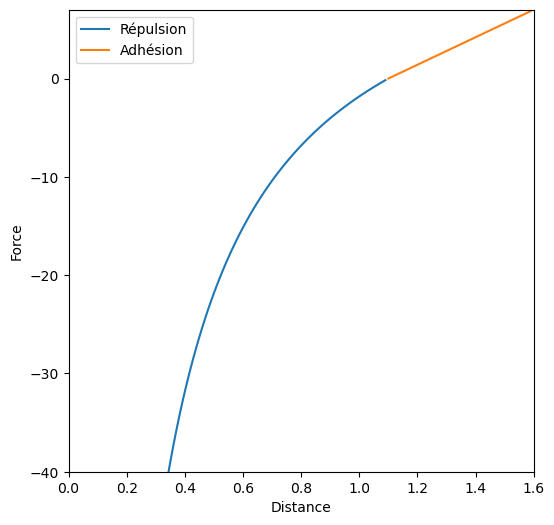

105 cellules


KeyboardInterrupt: 

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

### Importation des bibliothèques ###
import math
import os
import sys
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import trackpy as tp
import functions_analyze as lib
from scipy.signal import find_peaks

# Définition de l'appareil (CPU ou GPU) pour les opérations PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Appareil pour les opérations torch :", device)

def force_field_inbox(coordinates_diff, distances, Req, R0, Frep, Fadh,
                      coeff_a=None, coeff_rep=None):
    """
    Calcule le champ de forces entre les cellules en prenant en compte les forces
    de répulsion et d'adhésion, selon les distances entre les cellules.
    """
    Rlim = 1e-6  # Limite inférieure pour éviter la division par zéro
    R = torch.norm(coordinates_diff, dim=2)
    R = torch.where(R > Rlim, R, Rlim)

    force = torch.zeros_like(R)
    mask_adh = (R < R0) & (R > Req)
    force[mask_adh] = -((Fadh / (R0 - Req)) * R[mask_adh] - Fadh * Req / (R0 - Req))

    mask_rep = R <= Req
    force[mask_rep] = -Frep * coeff_rep * (1 / Req - 1 / R[mask_rep])

    normalized_diff = torch.nn.functional.normalize(coordinates_diff, dim=2)
    force_field = torch.sum(force[:, :, None] * normalized_diff, axis=1)

    return force_field

def plot_environment(cells, camp_field, space_size, axis, iteration=None):
    """
    Trace l'environnement de simulation, y compris les positions des cellules et
    la concentration du champ de cAMP.
    """
    axis.set_xlim(0, space_size)
    axis.set_ylim(0, space_size)

    extent = [0, space_size, 0, space_size]
    cmap = plt.cm.viridis
    im = axis.imshow(camp_field.signal.cpu().numpy().T, origin='lower', extent=extent, cmap=cmap, alpha=0.5)

    positions = torch.stack([cell.position for cell in cells]).cpu()
    x = positions[:, 0].numpy()
    y = positions[:, 1].numpy()

    colors = ['blue' if cell.pop == 'Population 1' else 'red' for cell in cells]

    axis.scatter(x, y, s=5, color=colors, alpha=0.5, edgecolors='k')

    axis.set_xlabel('Position X (micromètres)')
    axis.set_ylabel('Position Y (micromètres)')
    axis.set_title(f'Temps: {iteration * DELTA_T.item():.2f} min')

def plot_function(pas, Req, R0, Frep, Fadh, a, coeff_rep):
    """
    Trace les fonctions de force de répulsion et d'adhésion en fonction de la distance.
    """
    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, R0)
    plt.ylim(-Frep, Fadh)

    R_rep = np.arange(pas, Req, pas)
    force_rep = Frep * coeff_rep * (1 / Req - 1 / R_rep)
    axis.plot(R_rep, force_rep, label='Répulsion')

    R_adh = np.arange(Req, R0, pas)
    force_adh = (Fadh / (R0 - Req)) * (R_adh - Req)
    axis.plot(R_adh, force_adh, label='Adhésion')

    plt.xlabel('Distance')
    plt.ylabel('Force')
    plt.legend()
    plt.show()

def autovel(dX, n, tau, noise, dt, persistence):
    """
    Calcule la nouvelle direction des cellules basée sur leur déplacement,
    leur direction précédente, le bruit, le temps caractéristique tau, et la persistance.

    Paramètres:
    - dX: Tensor de déplacement des cellules (N x 2)
    - n: Tensor des directions précédentes des cellules (N x 2)
    - tau: Tensor des tau pour chaque cellule (N)
    - noise: Tensor du bruit pour chaque cellule (N)
    - dt: Tenseur scalaire du pas de temps
    - persistence: Tensor de persistance pour chaque cellule (N)

    Retourne:
    - new_direction: Tensor des nouvelles directions (N x 2)
    """
    dX_norm = torch.nn.functional.normalize(dX, dim=1) * 0.9999999

    # Si persistence est un tenseur, on traite les cas où elle est égale à 1
    persistence = torch.where(persistence == 1, torch.tensor(0.9999999, device=device), persistence)

    theta = torch.atan2(dX_norm[:, 1], dX_norm[:, 0])
    dtheta = torch.arcsin(n[:, 0] * dX_norm[:, 1] - n[:, 1] * dX_norm[:, 0]) * dt / tau

    # Assurez-vous que dt est un tenseur scalaire
    rnd = (2 * math.pi * (torch.rand(len(dX), device=device) - 0.5)) * noise * torch.sqrt(dt)

    theta_update = theta + dtheta + rnd
    new_direction = torch.stack((torch.cos(theta_update), torch.sin(theta_update)), dim=1)
    return new_direction

def compute_local_gradient(signal_grid, positions, grid_resolution):
    """
    Calcule le gradient du cAMP aux positions données.
    """
    grad_x = (torch.roll(signal_grid, shifts=-1, dims=0) - torch.roll(signal_grid, shifts=1, dims=0)) / (2 * grid_resolution)
    grad_y = (torch.roll(signal_grid, shifts=-1, dims=1) - torch.roll(signal_grid, shifts=1, dims=1)) / (2 * grid_resolution)

    x_indices = (positions[:, 0] / grid_resolution).long() % signal_grid.shape[0]
    y_indices = (positions[:, 1] / grid_resolution).long() % signal_grid.shape[1]

    cell_grad_x = grad_x[x_indices, y_indices]
    cell_grad_y = grad_y[x_indices, y_indices]

    gradients = torch.stack((cell_grad_x, cell_grad_y), dim=1)
    return gradients

class CellAgent:
    def __init__(self, id, pop, position, velocity,
                 velocity_magnitude, persistence, space_size,
                 tau, noise, cell_params, sensitivity_cAMP_threshold):
        """
        Classe représentant une cellule individuelle dans la simulation.
        """
        self.id = id
        self.pop = pop
        self.position_init = position.clone().to(device)
        self.position = position.clone().to(device)
        self.velocity = velocity.clone().to(device)
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.space_size = space_size
        self.tau = tau
        self.noise = noise
        self.direction = torch.nn.functional.normalize(velocity, p=2, dim=0)
        self.A = torch.tensor(0.5, device=device)
        self.R = torch.tensor(0.5, device=device)
        self.cell_params = cell_params
        self.D = cell_params['D']
        self.a0 = cell_params['a0']
        self.af = cell_params['af']
        self.sensitivity_threshold = sensitivity_cAMP_threshold

class Population:
    def __init__(self, num_cells, space_size, velocity_magnitude,
                 persistence, min_distance, pop_tag, ecart_type,
                 tau, noise, cell_params, sensitivity_cAMP_threshold):
        """
        Classe représentant une population de cellules.
        """
        self.num_cells = num_cells
        self.space_size = space_size
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.min_distance = min_distance
        self.pop_tag = pop_tag
        self.ecart_type = ecart_type
        self.tau = tau
        self.noise = noise
        self.cell_params = cell_params
        self.sensitivity_cAMP_threshold = sensitivity_cAMP_threshold
        self.cells = []
        self.initialize_cells()

    def initialize_cells(self):
        global cell_id_counter
        positions = torch.rand((self.num_cells, 2), device=device) * self.space_size
        directions = torch.nn.functional.normalize(torch.empty_like(positions).uniform_(-1, 1), dim=1)
        vitesses_gaussiennes = torch.normal(mean=self.velocity_magnitude, std=self.ecart_type, size=(self.num_cells,), device=device)

        for i in range(self.num_cells):
            velocity = directions[i] * vitesses_gaussiennes[i]
            self.cells.append(CellAgent(cell_id_counter, self.pop_tag, positions[i], velocity,
                                        vitesses_gaussiennes[i], self.persistence, self.space_size,
                                        self.tau, self.noise, self.cell_params, self.sensitivity_cAMP_threshold))
            cell_id_counter += 1

class Surface:
    def get_friction(self, position):
        friction = torch.empty(1, device=device).uniform_(0, 0.2)
        return friction.item()

class cAMP:
    def __init__(self, space_size, cell_params, initial_condition=None):
        """
        Classe représentant le champ de concentration du cAMP dans l'espace.
        """
        self.space_size = space_size
        self.grid_resolution = cell_params['grid_resolution']
        self.grid_size = int(space_size / self.grid_resolution)
        self.D_cAMP = cell_params['D_cAMP']
        self.aPDE = cell_params['aPDE']
        self.a0 = cell_params['a0']
        self.dx = self.grid_resolution
        self.dt = DELTA_T

        if initial_condition is None:
            self.signal = torch.zeros((self.grid_size, self.grid_size), device=device)
        else:
            if callable(initial_condition):
                self.signal = initial_condition(self.X, self.Y)
            elif isinstance(initial_condition, torch.Tensor):
                if initial_condition.shape == (self.grid_size, self.grid_size):
                    self.signal = initial_condition.to(device)
                else:
                    raise ValueError("La forme de initial_condition ne correspond pas à la grille.")
            else:
                self.signal = torch.full((self.grid_size, self.grid_size), initial_condition, device=device)

    def compute_laplacian(self, S):
        laplacian_S = (
            torch.roll(S, shifts=1, dims=0) + torch.roll(S, shifts=-1, dims=0) +
            torch.roll(S, shifts=1, dims=1) + torch.roll(S, shifts=-1, dims=1) -
            4 * S
        ) / self.dx ** 2
        return laplacian_S

    def update(self, cells):
        """
        Met à jour la concentration du cAMP en fonction de la production par les cellules,
        de la diffusion et de la dégradation.
        """
        cell_positions = torch.stack([cell.position for cell in cells])
        cell_As = torch.stack([cell.A for cell in cells])
        cell_a0s = torch.tensor([cell.a0 for cell in cells], device=device)
        cell_Ds = torch.tensor([cell.D for cell in cells], device=device)
        cell_afs = torch.tensor([cell.af for cell in cells], device=device)

        x_indices = (cell_positions[:, 0] / self.grid_resolution).long() % self.grid_size
        y_indices = (cell_positions[:, 1] / self.grid_resolution).long() % self.grid_size
        indices = x_indices * self.grid_size + y_indices

        A_grid = torch.zeros(self.grid_size * self.grid_size, device=device)

        A_grid.index_add_(0, indices, cell_a0s)

        active_cells = cell_As > cell_afs
        A_grid.index_add_(0, indices[active_cells], cell_Ds[active_cells])

        A_grid = A_grid.view(self.grid_size, self.grid_size)

        laplacian_S = self.compute_laplacian(self.signal)
        self.signal += self.dt * (self.D_cAMP * laplacian_S - self.aPDE * self.signal + A_grid)
        self.signal = torch.clamp(self.signal, min=0)

    def get_signal_at_positions(self, positions):
        x_indices = (positions[:, 0] / self.grid_resolution).long() % self.grid_size
        y_indices = (positions[:, 1] / self.grid_resolution).long() % self.grid_size
        return self.signal[x_indices, y_indices]

PLOT = True

# In[Paramètres de simulation]
SPACE_SIZE = 50  # Taille de l'espace de simulation en micromètres

# Paramètres des cellules pour le modèle de FitzHugh-Nagumo
cell_params = {
    'c0': 1.0,
    'a': 5.0,
    'gamma': 0.1,
    'Kd': 0.5,
    'sigma': 0.05,
    'epsilon': 0.2,
    'D': 150.0,
    'a0': 0.0,
    'af': 0.1,
    'noise': True,
    'D_cAMP': 400.0,
    'aPDE': 1.0,
    'grid_resolution': 0.5,
    'chemotaxis_sensitivity': 0.5
}

# DELTA_T est maintenant un tenseur
DELTA_T_value = (cell_params['grid_resolution']**2)/(4*cell_params['D_cAMP'])
DELTA_T = torch.tensor(DELTA_T_value, device=device)

TIME_SIMU = 1000  # Temps total de simulation en minutes
PLOT_INTERVAL = 100
MU = 1
F_REP = 40
F_ADH = 7
R_EQ = 1.1
R_0 = 1.6
MIN_DISTANCE_INIT = R_EQ
COEFF_CARRE = 50
COEFF_REP = 0.5
plot_function(pas=0.01, Req=R_EQ, R0=R_0, Frep=F_REP,
              Fadh=F_ADH, a=COEFF_CARRE, coeff_rep=COEFF_REP)

FLUCTUATION_FACTOR = 3
PACKING_FRACTION = 0.04
N_CELLS = int((PACKING_FRACTION * SPACE_SIZE ** 2) /
              (math.pi * ((R_EQ / 2) ** 2)))
print(N_CELLS, "cellules")

velocity_magnitude_pop1 = 0 * 3
ECART_TYPE_POP1 = 0.3
NOISE_POP_1 = 0 * 8
TAU_POP_1 = 5
PERSISTENCE_POP1 = 0
SENSITIVITY_cAMP_THRESHOLD_POP1 = 0.1

velocity_magnitude_pop2 = 0 * 8
ECART_TYPE_POP2 = 0.5
NOISE_POP_2 = 0 * 5
TAU_POP_2 = 5
PERSISTENCE_POP2 = 0
SENSITIVITY_cAMP_THRESHOLD_POP2 = 0.1

R_SENSING_GRAD = 10.0

# Définition des populations
cell_id_counter = 0
population1 = Population(num_cells=int(N_CELLS / 2), space_size=SPACE_SIZE,
                         velocity_magnitude=velocity_magnitude_pop1,
                         persistence=PERSISTENCE_POP1, ecart_type=ECART_TYPE_POP1,
                         min_distance=MIN_DISTANCE_INIT, pop_tag="Population 1",
                         tau=TAU_POP_1, noise=NOISE_POP_1, cell_params=cell_params,
                         sensitivity_cAMP_threshold=SENSITIVITY_cAMP_THRESHOLD_POP1)

population2 = Population(num_cells=int(N_CELLS / 2), space_size=SPACE_SIZE,
                         velocity_magnitude=velocity_magnitude_pop2,
                         persistence=PERSISTENCE_POP2, ecart_type=ECART_TYPE_POP2,
                         min_distance=MIN_DISTANCE_INIT, pop_tag="Population 2",
                         tau=TAU_POP_2, noise=NOISE_POP_2, cell_params=cell_params,
                         sensitivity_cAMP_threshold=SENSITIVITY_cAMP_THRESHOLD_POP2)

# Combinaison des cellules des deux populations
cells = population1.cells + population2.cells

surface = Surface()  # Création d'une instance de Surface (non utilisée ici)

# In[Initialisation]

def gradient_initial_condition(X, Y):
    return torch.full_like(X, 0.5, device=device)

# # Fonction pour créer un gradient de concentration de 0 en haut à 100 en bas
# def gradient_initial_condition(X, Y):
#     return (Y / SPACE_SIZE) * 100.0  # Y varie de 0 à SPACE_SIZE

##### Gradient linéaire max au centre min en hau et bas #######
# def gradient_initial_condition(X, Y):
#     max_concentration = 25.0  # Valeur maximale de la concentration au milieu
#     return (max_concentration * (1 - ((2 * (Y - SPACE_SIZE / 2) / SPACE_SIZE) ** 2))).to(device)

##### Gradient linéaire radial partant du centre #######
# def gradient_initial_condition(X, Y):
#     X_c = SPACE_SIZE / 2
#     Y_c = SPACE_SIZE / 2
#     R_max = math.sqrt(2) * (SPACE_SIZE / 2)  # Distance maximale au coin de l'espace
#     R = torch.sqrt((X - X_c) ** 2 + (Y - Y_c) ** 2)
#     max_concentration = 10.0
#     signal = max_concentration * (1 - R / R_max)
#     signal = torch.clamp(signal, min=0.0)  # Éviter les valeurs négatives
#     return signal.to(device)

# Initialisation de la grille de cAMP avec le gradient initial
camp_field = cAMP(SPACE_SIZE, cell_params,
                  initial_condition=None)

positions = torch.stack([cell.position for cell in cells])
V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device=device).unsqueeze(1)
direction = torch.stack([cell.direction for cell in cells])
positions = torch.stack([cell.position for cell in cells])

# Plot de l'état initial
if PLOT:
    PATH = f'./simu/v1{velocity_magnitude_pop1}v2{velocity_magnitude_pop2}a{COEFF_CARRE}coefrep{COEFF_REP}fadh{F_ADH}frep{F_REP}/'
    if not os.path.exists(PATH):
        os.makedirs(PATH)
    else:
        print("ATTENTION : LE DOSSIER EXISTE DÉJÀ !")
        sys.exit(0)
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_environment(cells, camp_field, SPACE_SIZE, axis=ax, iteration=0)
    plt.savefig(f'{PATH}image_0.png', bbox_inches='tight', dpi=300, pad_inches=0)
    plt.close()

# In[Simulation]
time = 0
iteration = 1
MAX_DISTANCE = np.sqrt(2 * (SPACE_SIZE / 2) ** 2)
data_list = []
while time < TIME_SIMU:
    # Récupération des attributs des cellules
    cell_positions = torch.stack([cell.position for cell in cells])
    cell_directions = torch.stack([cell.direction for cell in cells])
    cell_As = torch.stack([cell.A for cell in cells])
    cell_Rs = torch.stack([cell.R for cell in cells])
    cell_params_a = torch.tensor([cell.cell_params['a'] for cell in cells], device=device)
    cell_params_Kd = torch.tensor([cell.cell_params['Kd'] for cell in cells], device=device)
    cell_params_gamma = torch.tensor([cell.cell_params['gamma'] for cell in cells], device=device)
    cell_params_c0 = torch.tensor([cell.cell_params['c0'] for cell in cells], device=device)
    cell_params_epsilon = torch.tensor([cell.cell_params['epsilon'] for cell in cells], device=device)
    cell_params_sigma = torch.tensor([cell.cell_params['sigma'] for cell in cells], device=device)
    cell_afs = torch.tensor([cell.af for cell in cells], device=device)
    cell_pops = [cell.pop for cell in cells]

    # Extraction de tau, noise et persistence
    taus = torch.tensor([cell.tau for cell in cells], device=device)
    noises = torch.tensor([cell.noise for cell in cells], device=device)
    persistences = torch.tensor([cell.persistence for cell in cells], device=device)

    # Obtenir la concentration de cAMP aux positions des cellules
    signal_values = camp_field.get_signal_at_positions(cell_positions)

    # Mise à jour des états A et R des cellules
    I_S = cell_params_a * torch.log1p(signal_values / cell_params_Kd)
    dA = (cell_As - (cell_As ** 3) / 3 - cell_Rs + I_S) * DELTA_T
    dA += cell_params_sigma * torch.sqrt(DELTA_T) * torch.randn_like(cell_As, device=device)
    cell_As += dA
    dR = (cell_As - cell_params_gamma * cell_Rs + cell_params_c0) * cell_params_epsilon * DELTA_T
    cell_Rs += dR

    # Mise à jour des attributs des cellules
    for i, cell in enumerate(cells):
        cell.A = cell_As[i]
        cell.R = cell_Rs[i]

    # Mise à jour de la grille de cAMP
    camp_field.update(cells)

    # Calcul du gradient du cAMP pour chaque cellule et ajustement de la direction
    gradients = compute_local_gradient(camp_field.signal, cell_positions, camp_field.grid_resolution)
    local_camp_concentrations = signal_values
    chemotaxis_mask = local_camp_concentrations >= torch.tensor([cell.sensitivity_threshold for cell in cells], device=device)

    # Normalisation des gradients
    gradients_norm = torch.norm(gradients, dim=1, keepdim=True)
    gradients_norm[gradients_norm == 0] = 1
    gradients_normalized = gradients / gradients_norm

    # Mise à jour des directions en tenant compte de la chimiotaxie
    chemotaxis_sensitivity = cell_params['chemotaxis_sensitivity']
    cell_directions = torch.where(
        chemotaxis_mask.unsqueeze(1),
        (1 - chemotaxis_sensitivity) * cell_directions + chemotaxis_sensitivity * gradients_normalized,
        cell_directions
    )
    cell_directions = torch.nn.functional.normalize(cell_directions, dim=1)

    # Calcul des différences de coordonnées entre les cellules (pour les forces)
    coordinates_diff = ((cell_positions[:, None, :] - cell_positions[None, :, :]))
    coordinates_diff = torch.remainder(coordinates_diff - (SPACE_SIZE / 2), SPACE_SIZE) - (SPACE_SIZE / 2)
    distances = torch.norm(coordinates_diff, dim=2)

    # Calcul du champ de forces entre les cellules
    force_field = force_field_inbox(coordinates_diff, distances, Req=R_EQ,
                                    R0=R_0, Frep=F_REP, Fadh=F_ADH,
                                    coeff_a=COEFF_CARRE, coeff_rep=COEFF_REP)

    # Calcul du déplacement des cellules
    V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device=device).unsqueeze(1)
    fluctuations = (torch.rand(V0.shape, device=device) - 0.5) * FLUCTUATION_FACTOR
    displacement = MU * force_field * DELTA_T + (V0 + fluctuations) * cell_directions * DELTA_T

    # Mise à jour des positions des cellules
    cell_positions += displacement
    cell_positions = torch.remainder(cell_positions, SPACE_SIZE)

    # Mise à jour des directions des cellules
    cell_directions = autovel(displacement, cell_directions, tau=taus, noise=noises, dt=DELTA_T, persistence=persistences)

    # Mise à jour des attributs des cellules
    for i, cell in enumerate(cells):
        cell.position = cell_positions[i]
        cell.direction = cell_directions[i]

        # Enregistrement des informations de la cellule pour l'analyse
        data_list.append({
            'frame': time,
            'particle': cell.id,
            'pop_tag': cell.pop,
            'x': cell.position[0].item(),
            'y': cell.position[1].item(),
            'dir_x': cell.direction[0].item(),
            'dir_y': cell.direction[1].item()
        })

    # ... (le reste du code inchangé)

    # Mise à jour du temps et de l'itération
    time += DELTA_T.item()
    iteration += 1
